See [fast_wcs_interp_torch_experiments_part3](fast_wcs_interp_torch_experiments_part3.ipynb) for previous part.

From those we find that just using the poly directly seems superior to any NN.  So here we implement that a little bit more cleanly and try fiddling with HPs a bit.

In [1]:
import time
from pathlib import Path
import itertools

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import constants

from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler


from jwst import datamodels

%matplotlib inline
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

### Cuda/torch preliminaries

In [2]:
import os
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [3]:
for nm in 'cpu,cuda,cudnn,mps,mkl,mkldnn,openmp'.split(','):
    be = getattr(torch.backends, nm)
    built = be.is_built() if hasattr(be, 'is_built') else None
    avail = be.is_available() if hasattr(be, 'is_available') else None
    if avail is None and nm == 'cuda':
        avail = torch.cuda.is_available()
    print(nm, built, avail) 

torch_device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {torch_device} device")

cpu None None
cuda True True
cudnn None True
mps False False
mkl None True
mkldnn None True
openmp None True
Using cuda device


In [4]:
def dconvert32(x):
    cons = torch.from_numpy if isinstance(x, np.ndarray) else torch.Tensor
    return cons(x).to(torch_device, dtype=torch.float32)
def dconvert64(x):
    cons = torch.from_numpy if isinstance(x, np.ndarray) else torch.Tensor
    return cons(x).to(torch_device, dtype=torch.float64)

# Poly-model

In [5]:
class ExpandToPoly(nn.Module):
    def __init__(self, polydeg, in_n):
        super().__init__()
        self._in_n = in_n
        self._polydeg = polydeg

        self.register_buffer('poly_powers', torch.from_numpy(self.make_power_array(polydeg, in_n)[..., np.newaxis].T))


    @property
    def in_n(self):
        return self._in_n
    @property
    def polydeg(self):
        return self._polydeg
    @property
    def out_n(self):
        return self.poly_powers.shape[-1]

    @staticmethod
    def make_power_array(degree, nfeaturesin):
        combs = [(),]
        for i in range(degree):
            combs.extend(itertools.combinations_with_replacement(range(nfeaturesin), i+1))
        pwr = np.zeros((len(combs), nfeaturesin))
        for i in range(len(combs)):
            for j in combs[i]:
                pwr[i, j] += 1
        return pwr

    def forward(self, x):
        xt = x[..., np.newaxis]
        xp = xt**self.poly_powers
        return torch.prod(xp, 1)

test_poly = ExpandToPoly(4,2)
assert test_poly.out_n == 15
assert test_poly.to(dtype=torch.float32).poly_powers.dtype == torch.float32
test_poly

ExpandToPoly()

In [6]:
class RescalingPolyModel(nn.Module):
    def __init__(self, inbounds, outbounds, polydeg, transfer_layer_n=None):
        super().__init__()

        in_n = len(inbounds)
        self.inscale = [float(u-l) for l, u in inbounds]
        self.inoffset = [float(l) for l, u in inbounds]

        iscale_inv = 1/torch.tensor(self.inscale)
        self.inscale_layer = nn.Linear(in_n, in_n)
        self.inscale_layer.weight = nn.Parameter(torch.diag(iscale_inv), requires_grad=False)
        self.inscale_layer.bias = nn.Parameter(-torch.tensor(self.inoffset)*iscale_inv, requires_grad=False)
        
        out_n = len(outbounds)
        self.outscale = [float(u-l) for l, u in outbounds]
        self.outoffset = [float(l) for l, u in outbounds]

        self.outscale_layer = nn.Linear(out_n, out_n)
        self.outscale_layer.weight = nn.Parameter(torch.diag(torch.tensor(self.outscale)), requires_grad=False)
        self.outscale_layer.bias = nn.Parameter(torch.tensor(self.outoffset), requires_grad=False)

        self.poly_layer = ExpandToPoly(polydeg=polydeg, in_n=in_n)

        self.coeffs = nn.Linear(self.poly_layer.out_n, out_n, bias=False)
            
        self.primary_stack = nn.Sequential(self.inscale_layer,
                                            self.poly_layer,
                                            self.coeffs,
                                            self.outscale_layer)

    @property
    def in_n(self):
        return self.inscale_layer.in_features

    @property
    def out_n(self):
        return self.outscale_layer.out_features

    def forward(self, x):
        assert x.shape[-1] == self.in_n
        
        leading_dims = x.shape[:-1]
        xflat = x.reshape(x.shape.numel() // self.in_n, self.in_n)

        yflat = self.primary_stack(xflat)

        return yflat.reshape(*leading_dims, self.out_n)


    def set_coeffs_for_lstsq_solution(self, x, y, subsample=None, seed=42):
        assert x.shape[-1] == self.in_n
        assert y.shape[-1] == self.out_n
        xflat = x.reshape(x.shape.numel() // self.in_n, self.in_n)
        yflat = y.reshape(y.shape.numel() // self.out_n, self.out_n)

        if subsample is not None:
            if seed is not None:
                torch.manual_seed(seed)
            ssample = torch.randperm(xflat.shape[0])[:subsample]
            xflat = xflat[ssample]
            yflat = yflat[ssample]

        p = self.poly_layer(self.inscale_layer(xflat))
        ydescaled = (yflat - self.outscale_layer.bias)/self.outscale_layer.weight.diag()

        soln = torch.linalg.lstsq(p, ydescaled)
        self.coeffs.weight = nn.Parameter(torch.Tensor(soln.solution.T))

        return soln
        
    # def inrescale(self, x):
    #     return (x - self.inoffset)/self.inscale

    # def outrescale(self, y):
    #     return y * self.outscale + self.outoffset


model_test = RescalingPolyModel([(1,2), (3,4)], [(5,6)], 3).to(dtype=torch.float32)

in_test = torch.tensor([[1.5, 3.5]]).to(dtype=torch.float32)
np.testing.assert_allclose(model_test.inscale_layer(in_test).cpu().numpy()[0], np.array([0.5,0.5]))
res_test = model_test(in_test)
res_test, (res_test - model_test.outscale_layer.bias)/model_test.outscale_layer.weight

(tensor([[4.8956]], grad_fn=<ViewBackward0>),
 tensor([[-0.1044]], grad_fn=<DivBackward0>))

In [7]:
model_test.inscale_layer(in_test)

tensor([[0.5000, 0.5000]])

In [8]:
model_test.poly_layer(model_test.inscale_layer(in_test))

tensor([[1.0000, 0.5000, 0.5000, 0.2500, 0.2500, 0.2500, 0.1250, 0.1250, 0.1250,
         0.1250]])

In [9]:
model_test.set_coeffs_for_lstsq_solution(in_test, torch.Tensor([[2.5]]))
print(model_test(in_test))
model_test.set_coeffs_for_lstsq_solution(in_test, torch.Tensor([[5.5]]))
print(model_test(in_test))

tensor([[2.5000]], grad_fn=<ViewBackward0>)
tensor([[5.5000]], grad_fn=<ViewBackward0>)


OK this all looks right

# Data loading

In [10]:
slit_name = 's00066'

redux_path = Path(f'data/jwst_outputs/redux_{slit_name}/')

In [11]:
cal_paths = list(redux_path.glob('*cal.fits'))
cal_paths

[PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00002_nrs2_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00001_nrs1_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00002_nrs1_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00001_nrs2_cal.fits')]

In [12]:
cal_dms = {p.name: datamodels.open(p) for p in tqdm(cal_paths) if 'jw02609010001_03101_00002_nrs2_cal' in p.name}
cal_dms

  0%|          | 0/4 [00:00<?, ?it/s]

{'jw02609010001_03101_00002_nrs2_cal.fits': <MultiSlitModel from jw02609010001_03101_00002_nrs2_cal.fits>}

In [13]:
slit_all = {}
for k, dm in cal_dms.items():
    matches = np.array([s.source_id for s in dm.slits]) == 42
    assert np.sum(matches)==1
    idx = np.where(matches)[0][0]

    slit_all[k] = dm.slits[idx]

In [14]:
slit = slit_all['jw02609010001_03101_00002_nrs2_cal.fits']

In [15]:
#phoenix_model = fits.open('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z+0.5/lte04700-3.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits', cache=True)
phoenix_model = fits.open('phoenix/lte04700-3.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
#phoenix_wave = fits.getdata('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS//WAVE_PHOENIX-ACES-AGSS-COND-2011.fits', cache=True)*u.angstrom
phoenix_wave = fits.getdata('phoenix/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')*u.angstrom

phoenix_spec = Spectrum1D(spectral_axis=phoenix_wave, flux=phoenix_model[0].data*u.Unit(phoenix_model[0].header['BUNIT']))

2024-04-16 17:49:39,549 - stpipe - WARNING - UnitsWarning: 'erg/s/cm^2/cm' contains multiple slashes, which is discouraged by the FITS standard


In [16]:
def resample_to_slit(slit, model_spec=phoenix_spec, factor=10):
    wls = np.quantile(slit.wavelength[np.isfinite(slit.wavelength)], [0, .5,1])*u.micron

    msk = (wls[0] <= model_spec.spectral_axis) & (model_spec.spectral_axis<=wls[-1])

    phoenix_sub_spec = Spectrum1D(spectral_axis=model_spec.spectral_axis[msk], 
                                            flux=model_spec.flux[msk])

    dmodel = np.diff(model_spec.spectral_axis[msk])

    phoenix_lowres_wls_dlamb = np.max(dmodel)*factor
    phoenix_lowres_wl_bins = np.arange(wls[0].to(phoenix_lowres_wls_dlamb.unit).value, 
                                    wls[-1].to(phoenix_lowres_wls_dlamb.unit).value, 
                                    phoenix_lowres_wls_dlamb.to(phoenix_lowres_wls_dlamb.unit).value)*phoenix_lowres_wls_dlamb.unit

    return FluxConservingResampler().resample1d(phoenix_sub_spec, 
                                (phoenix_lowres_wl_bins[:-1] + phoenix_lowres_wl_bins[1:])/2)

phoenix_lowres = resample_to_slit(slit)
len(phoenix_lowres.spectral_axis)/slit.data.shape[1]  # tells how much better sampled the "low" res spectrum is from the data

11.77783203125

In [17]:
def ptrans_3feature(urand, sax):
    lptp = np.ptp(phoenix_lowres.spectral_axis)
    lmin = np.min(phoenix_lowres.spectral_axis)

    l = lptp*urand[0] + lmin
    ro = (urand[1]*2 - 1)
    do = (urand[2]*2 - 1)
    
    return l,ro << u.arcsec,do << u.arcsec


def make_grid_3feature(sizes, slit, sax=phoenix_lowres.spectral_axis, flatten=False, dconvert=dconvert32):
    mingrids = ptrans_3feature([0 for _ in sizes], sax)
    maxgrids = ptrans_3feature([1 for _ in sizes], sax)
    mgrids = [np.linspace(*e) for e in zip(mingrids, maxgrids, sizes)]
    l, ro, do = np.meshgrid(*mgrids)

    base_sc = SkyCoord(slit.source_ra<<u.deg, slit.source_dec<<u.deg)
    sc = base_sc.spherical_offsets_by(ro, do)
    outs = dconvert(slit.meta.wcs.world_to_pixel(sc, l))

    ins = dconvert((l.value, ro.value, do.value))

    ins = ins.permute(*np.roll(range(len(ins.shape)), -1))
    outs = outs.permute(*np.roll(range(len(outs.shape)), -1))

    if flatten:
        ins = ins.reshape(ins.shape.numel()//ins.shape[-1], ins.shape[-1])
        outs = outs.reshape(outs.shape.numel()//outs.shape[-1], outs.shape[-1])
    
    return ins, outs

grid_ins, grid_outs = make_grid_3feature((100,100,100), slit)
ins_plot, outs_plot = make_grid_3feature((17,17,17), slit, flatten=True)

/tmp/ipykernel_112/2397871784.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return cons(x).to(torch_device, dtype=torch.float32)


# Fitting experiments

In [80]:
def batch_train_from_pool(model, batch_size, n_batches, validation_period, 
                          pool=(grid_ins, grid_outs), valids=(grid_ins, grid_outs),
                          loss_fcn=None, optimizer=None, scheduler_gen=None, seed=42, shuffle=False):
    model = model.to(torch_device)
    
    if isinstance(seed, np.random.Generator):
        rng = seed
    else:
        rng = np.random.default_rng(seed)
        
    if loss_fcn is None:
        loss_fcn = model.loss_fcn = nn.MSELoss().to(torch_device, dtype=torch.float32)
    if optimizer is None:
        optimizer = model.optimizer = torch.optim.Adam(model.parameters())
    elif callable(optimizer):
        optimizer = optimizer(model)

    if scheduler_gen is None:
        scheduler = None
    else:
        scheduler = model.scheduler = scheduler_gen(optimizer)

    ins = pool[0]
    if len(ins.shape) != 2:
        ins = ins.reshape(ins.shape.numel()//ins.shape[-1], ins.shape[-1])
    outs = pool[1]
    if len(outs.shape) != 2:
        outs = outs.reshape(outs.shape.numel()//outs.shape[-1], outs.shape[-1])

    valid_ins = valids[0]
    if len(valid_ins.shape) != 2:
        valid_ins = valid_ins.reshape(valid_ins.shape.numel()//valid_ins.shape[-1], valid_ins.shape[-1])
    valid_outs = valids[1]
    if len(valid_outs.shape) != 2:
        valid_outs = valid_outs.reshape(valid_outs.shape.numel()//valid_outs.shape[-1], valid_outs.shape[-1])

    if not hasattr(model, 'batchis'):
        model.batchis = []
    if not hasattr(model, 'losses'):
        model.losses = []
        
    if not hasattr(model, 'batchis_validation'):
        model.batchis_validation = []
    if not hasattr(model, 'loss_validation'):
        model.loss_validation = []
        
    if not hasattr(model, 'learning_rates'):
        model.learning_rates = []

    llr = optimizer.param_groups[0]['lr']
    model.learning_rates.append((0, llr))
        
    pbar = tqdm(list(range(n_batches)))
    for batchi in pbar:
        if shuffle:
            rng.shuffle(idxs)
            samples = idxs[:batch_size]
        else:
            samples = rng.integers(ins.shape[0], size=batch_size)
            
        inb = ins[samples]
        outb = outs[samples]

        pred = model(inb)
        loss = loss_fcn(pred, outb)

        model.batchis.append(batchi)
        model.losses.append(loss.item())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batchi % validation_period == 0 or batchi == (n_batches-1):
            with torch.no_grad():
                model.eval()
                model.batchis_validation.append(batchi)
                model.loss_validation.append(loss_fcn(model(valid_ins), valid_outs).item())

            if scheduler is not None:
                scheduler.step(model.loss_validation[-1])
                if llr != scheduler.get_last_lr()[-1]:
                    model.learning_rates.append((batchi, scheduler.get_last_lr()[-1]))
                    llr = model.learning_rates[-1][1]

            pbar.set_description(f'validation loss: {model.loss_validation[-1]}, lr: {llr}')
            pbar.refresh()
        
    model.eval()
    return model

def training_plots(model, pdata=(ins_plot, outs_plot), skipstart=-1, trainplot=True, residualsplot=True):
    fig, axs = plt.subplots(int(trainplot) + int(residualsplot), 1, figsize=(12, 10))

    if not isinstance(axs, np.ndarray):
        axs = [axs]

    axi = 0
    if trainplot:
        axtrain = axs[axi]
        axi += 1
    if residualsplot:
        axres = axs[axi]
        axi += 1
        

    if trainplot:
        bi = np.array(model.batchis)
        ls = np.array(model.losses)
        biv = np.array(model.batchis_validation)
        lsv = np.array(model.loss_validation)

        msk1 = bi > skipstart
        msk2 = biv > skipstart
        
        axtrain.semilogy(bi[msk1], ls[msk1], '.', alpha=.5, ms=3, label='training')
        axtrain.semilogy(biv[msk2], lsv[msk2], 'o-', alpha=.5, label='validation')
        for lr in model.learning_rates:
            axtrain.axvline(lr[0], color='k', alpha=.75, ls=':')
        axtrain.legend(loc=0)
        axtrain.set_ylabel('loss')
        axtrain.set_xlabel('batch#')

    if residualsplot:
        pred = model(pdata[0])
        residuals = pred - pdata[1]
        
        for i, pxnm in enumerate('xy'):
            resi = residuals[:, i].detach().cpu()
            axres.scatter(np.arange(len(resi)), resi, s=2, label=pxnm, alpha=.5)
            axres.set_ylabel('residuals')
        axres.legend(loc=0)
        axres.set_xticks([])

    return fig

  0%|          | 0/20000 [00:00<?, ?it/s]

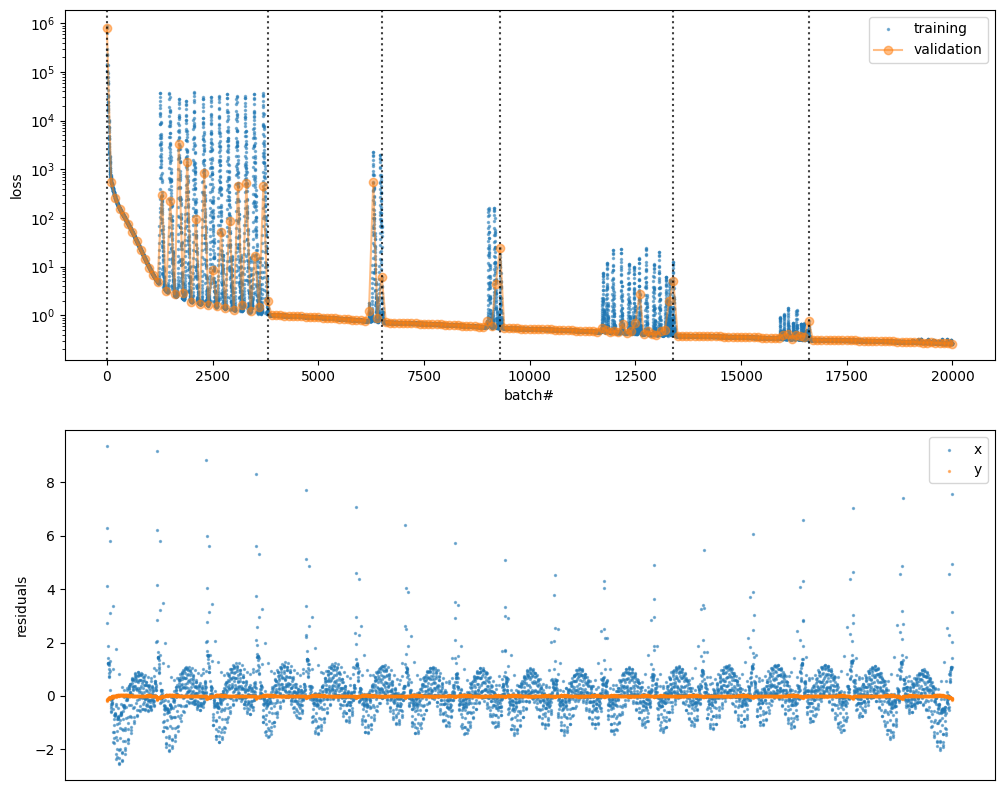

In [20]:
inscale = [(float(grid_ins[...,i].min()), float(grid_ins[...,i].max())) for i in range(grid_ins.shape[-1])]
outscale = [(float(grid_outs[...,i].min()), float(grid_outs[...,i].max())) for i in range(grid_outs.shape[-1])]
model = RescalingPolyModel(inscale, outscale, 4).to(torch_device, dtype=torch.float32)

model = batch_train_from_pool(model, 1024*200, 20000, 100,
                              optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-1, fused=True),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=3, factor=.3, threshold=.001))

training_plots(model);

In [ ]:
inscale = [(float(grid_ins[...,i].min()), float(grid_ins[...,i].max())) for i in range(grid_ins.shape[-1])]
outscale = [(float(grid_outs[...,i].min()), float(grid_outs[...,i].max())) for i in range(grid_outs.shape[-1])]
model = RescalingPolyModel(inscale, outscale, 4).to(torch_device, dtype=torch.float32)

model.set_coeffs_for_lstsq_solution(grid_ins, grid_outs, subsample=512)
plt.plot((model(ins_plot) - outs_plot).cpu().detach(), '.')

nn.MSELoss().to(torch_device, dtype=torch.float32)(model(grid_ins), grid_outs).item()

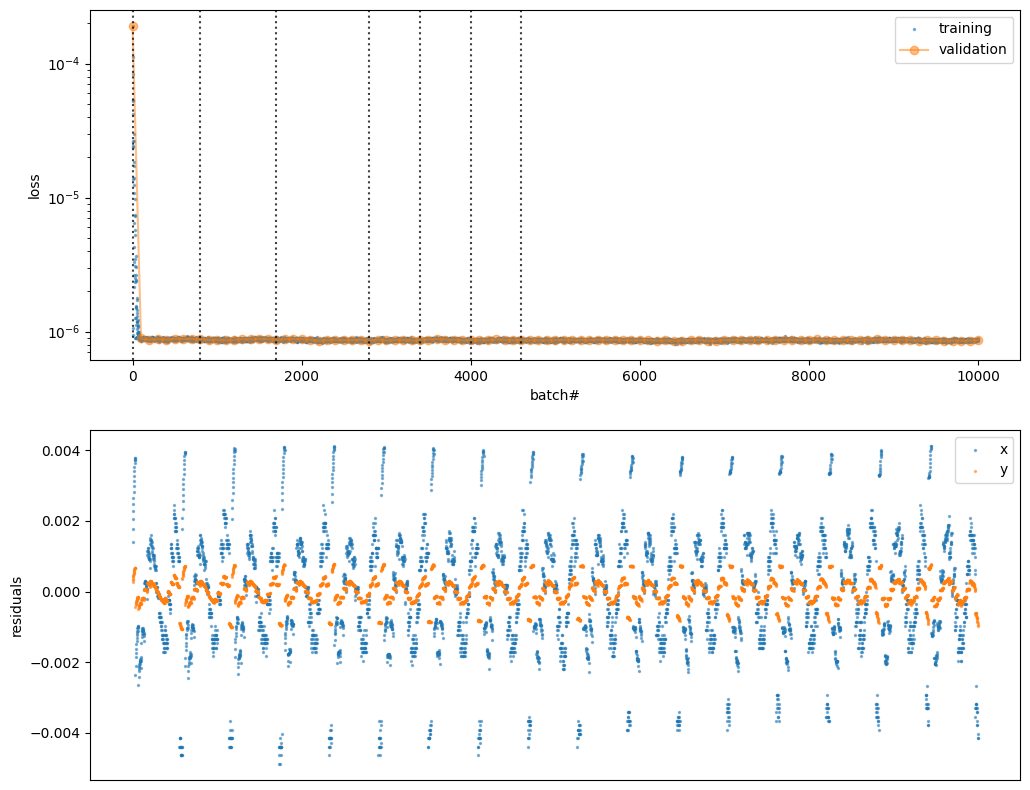

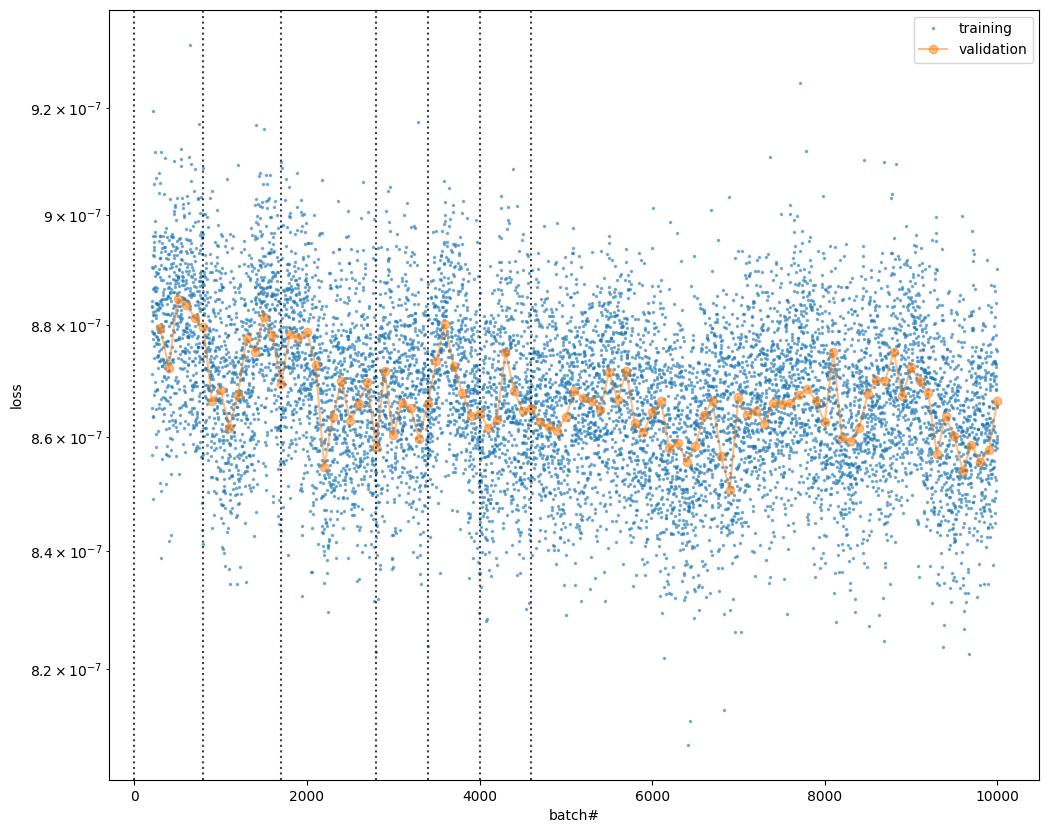

In [181]:
model = batch_train_from_pool(model, 1024*10, 10000, 100,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-6, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.5, threshold=.005))

training_plots(model)
training_plots(model, residualsplot=False, skipstart=200);

## Try doubles

In [193]:
grid_ins64, grid_outs64 = g64 = make_grid_3feature((100,100,100), slit_base_sc, dconvert=dconvert64 )
ins_plot64, outs_plot64 = p64 = make_grid_3feature((17,17,17), slit_base_sc, dconvert=dconvert64, flatten=True)

1.018311107297524e-06

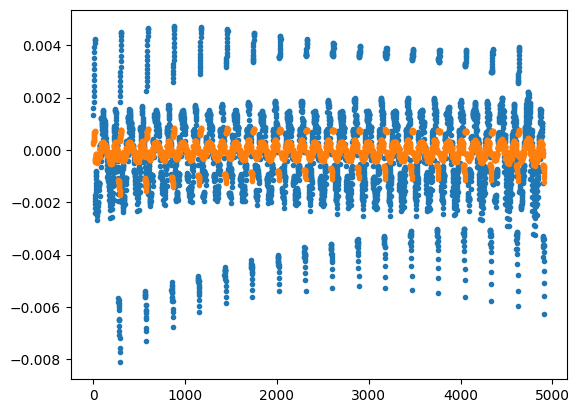

In [196]:
inscale = [(float(grid_ins64[...,i].min()), float(grid_ins64[...,i].max())) for i in range(grid_ins64.shape[-1])]
outscale = [(float(grid_outs64[...,i].min()), float(grid_outs64[...,i].max())) for i in range(grid_outs64.shape[-1])]
model = RescalingPolyModel(inscale, outscale, 4).to(torch_device, dtype=torch.float64)

model.set_coeffs_for_lstsq_solution(grid_ins64, grid_outs64, subsample=512)
plt.plot((model(ins_plot64) - outs_plot64).cpu().detach(), '.')

nn.MSELoss().to(torch_device, dtype=torch.float64)(model(grid_ins64), grid_outs64).item()

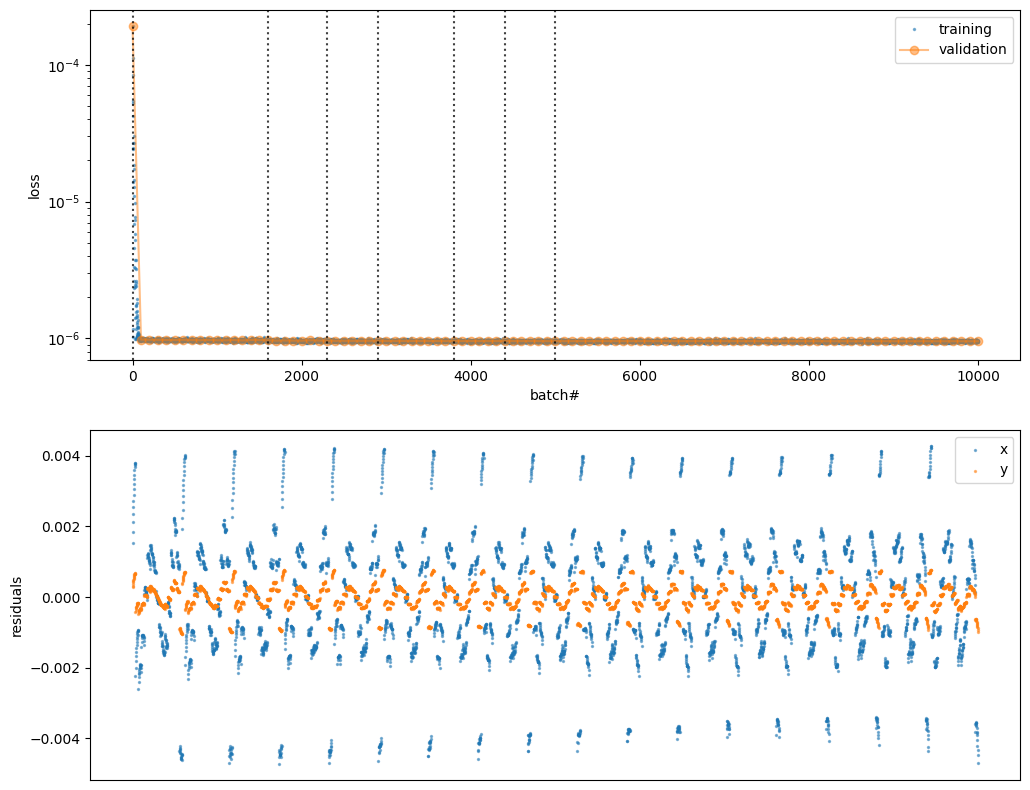

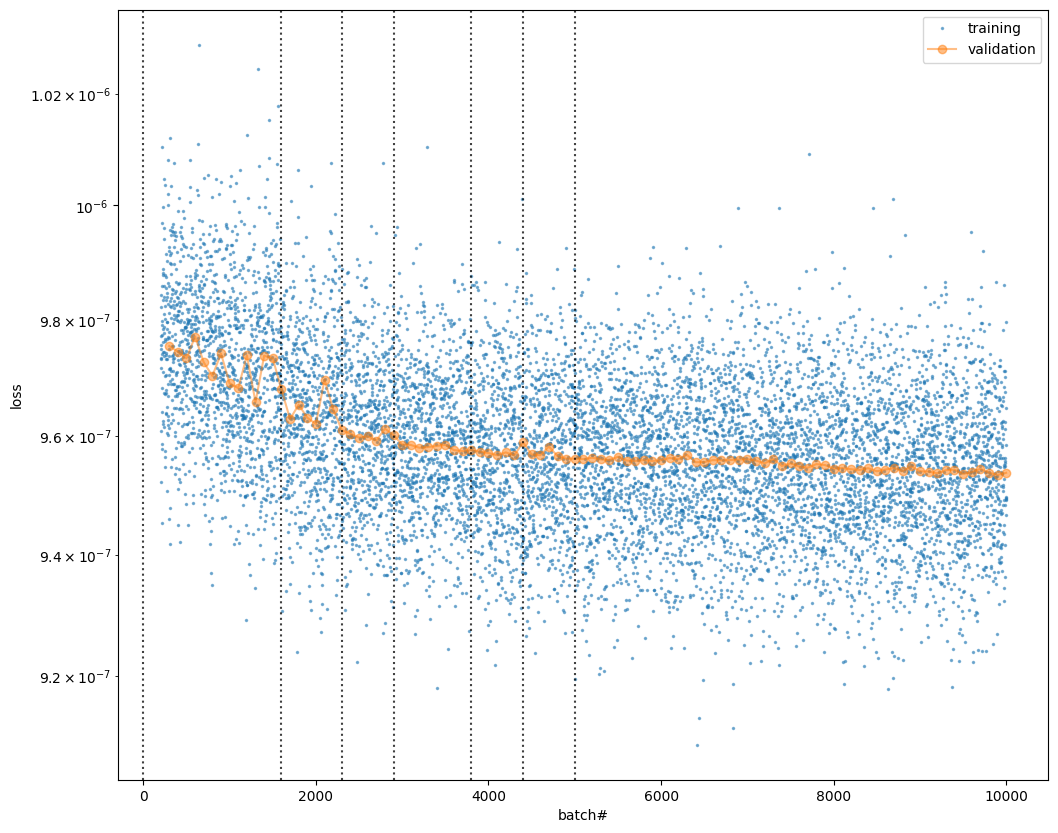

In [200]:
g64 = (grid_ins.to(dtype=torch.float64), grid_outs.to(dtype=torch.float64))
model = batch_train_from_pool(model, 1024*10, 10000, 100, 
                             pool=g64, valids=g64,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-6, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.5, threshold=.005))

training_plots(model, p64)
training_plots(model, p64, residualsplot=False, skipstart=200);

Well that's  mysterious that double are *worse*... but eh, move on.

# Compare across slits

In [30]:
cal_dms = {p.name: datamodels.open(p) for p in tqdm(cal_paths)}

slit_all = {}
for k, dm in cal_dms.items():
    matches = np.array([s.source_id for s in dm.slits]) == 42
    assert np.sum(matches)==1
    idx = np.where(matches)[0][0]

    slit_all[k] = dm.slits[idx]

  0%|          | 0/4 [00:00<?, ?it/s]

In [54]:
models = {}

t = tqdm(slit_all.items())
for nm, sliti in t:
    t1 = time.time()
    t.set_description(nm)
    t.refresh()

    phoenix_lowres_i = resample_to_slit(sliti)
    grid_ins, grid_outs = d = make_grid_3feature((100,100,100), sliti, sax=phoenix_lowres_i.spectral_axis)

    inscale = [(float(grid_ins[...,i].min()), float(grid_ins[...,i].max())) for i in range(grid_ins.shape[-1])]
    outscale = [(float(grid_outs[...,i].min()), float(grid_outs[...,i].max())) for i in range(grid_outs.shape[-1])]
    model = RescalingPolyModel(inscale, outscale, 4).to(torch_device, dtype=torch.float32)

    model.set_coeffs_for_lstsq_solution(grid_ins, grid_outs, subsample=512)

    model = batch_train_from_pool(model, 1024*25, 2500, 100, pool=d, valids=d,
            optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-6, fused=False),
            scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.5, threshold=.005))

    models[nm] = model
    t2 = time.time()
    model.runtime = t2-t1

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

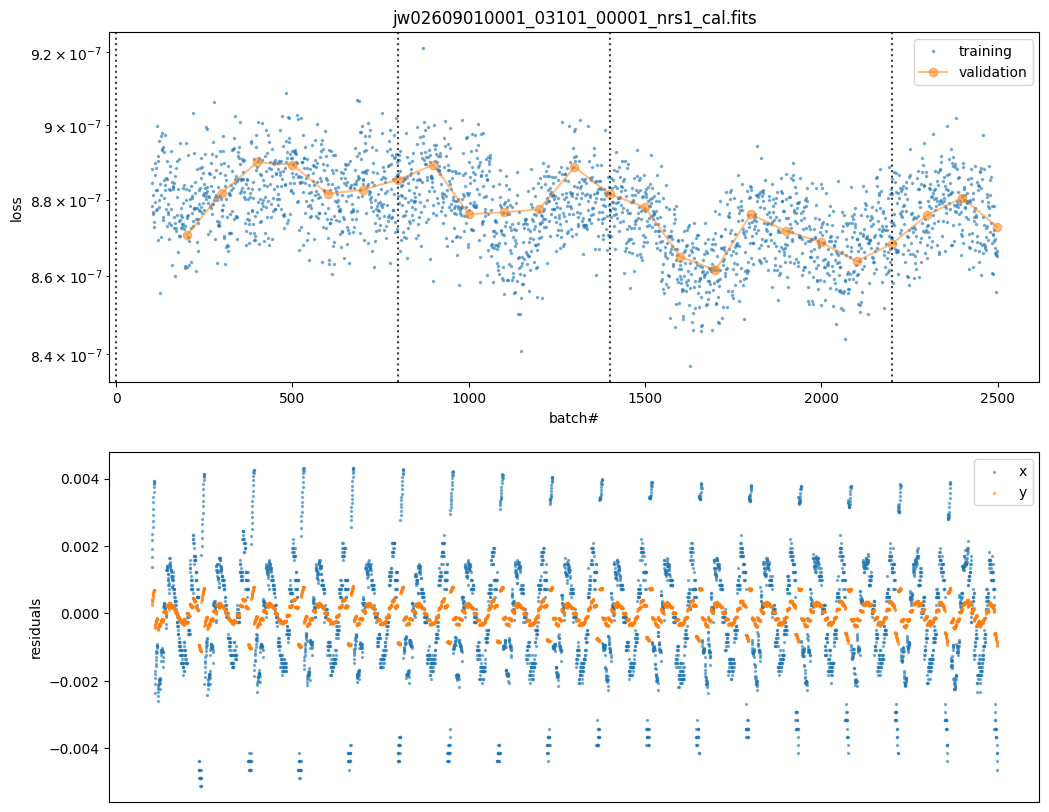

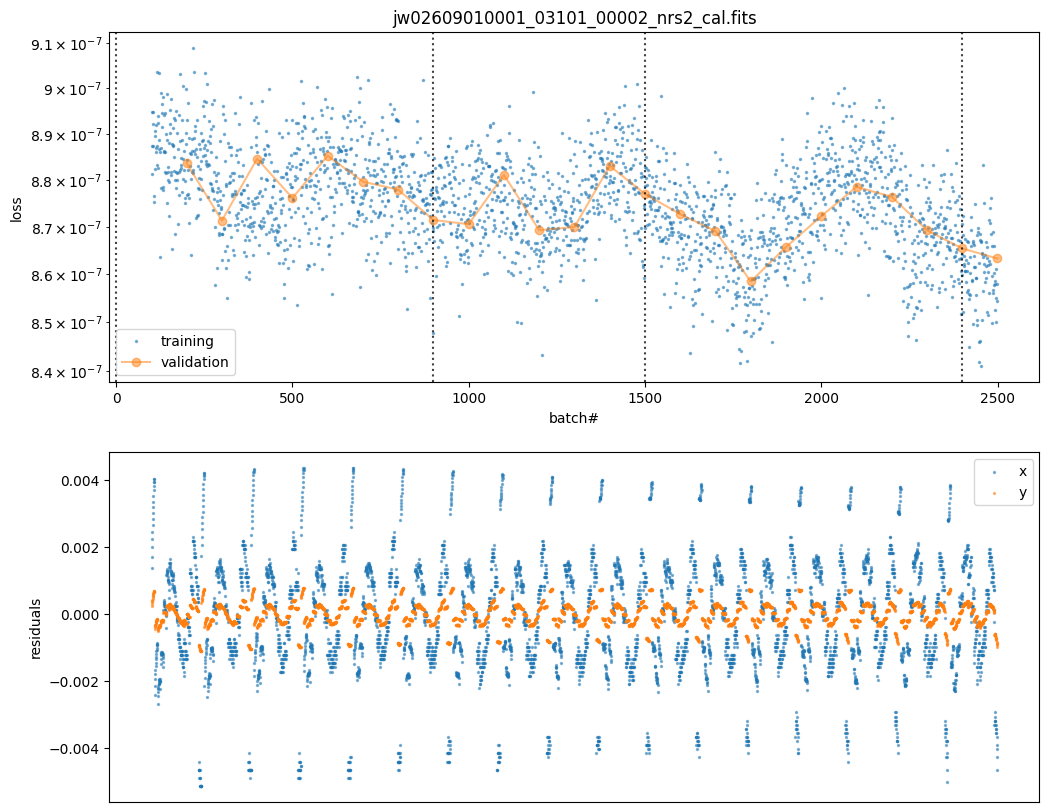

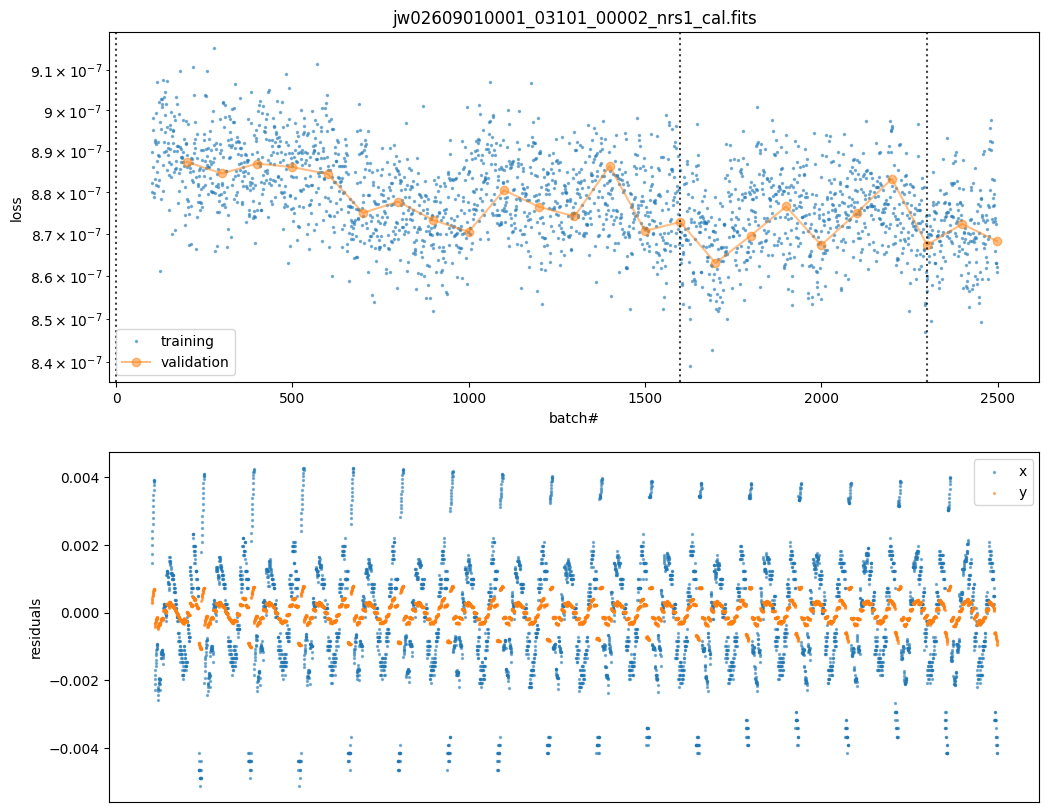

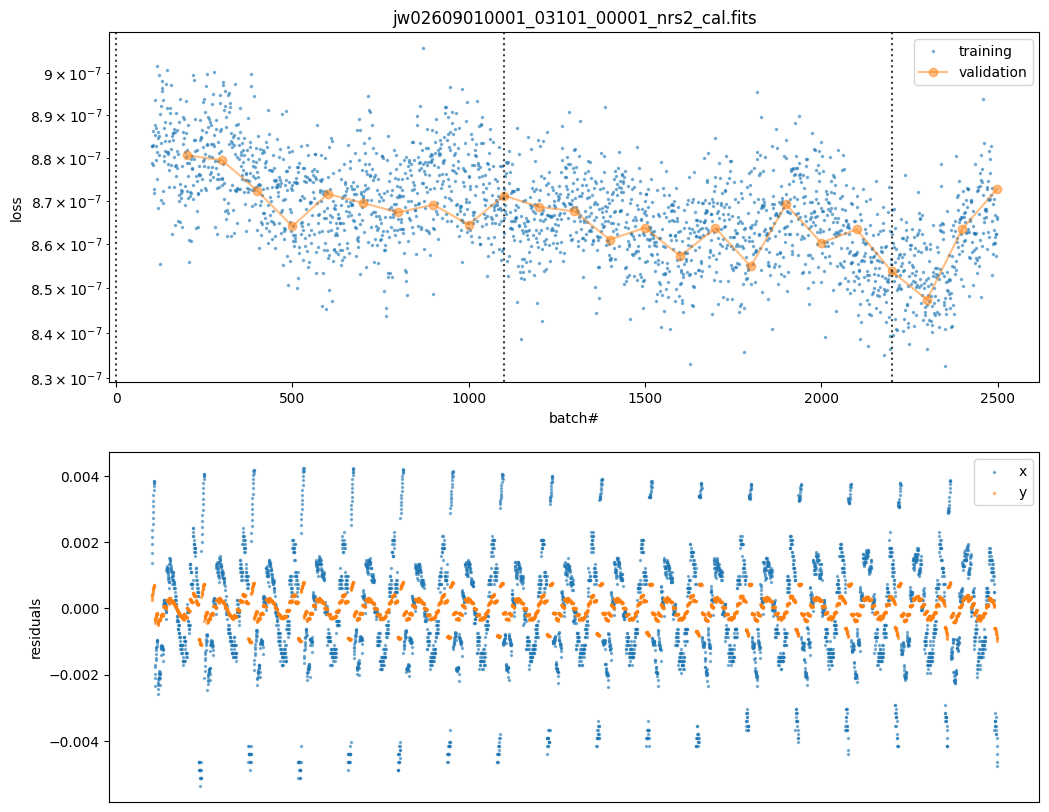

In [55]:
for nm,model in models.items():
    sliti = slit_all[nm]
    phoenix_lowres_i = resample_to_slit(sliti)
    pdat = make_grid_3feature((17,17,17), sliti, sax=phoenix_lowres_i.spectral_axis, flatten=True)

    fig = training_plots(model, pdat, skipstart=100)
    fig.axes[0].set_title(nm)

## Timing checks

In [75]:
slit.data.shape

(38, 2048)

Lets assume we want a grid that's 10x the spectral pixels but just one offset pixel (assuming we can express psf in pixels), how long does that take to infer?

In [100]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

wla = torch.arange(20480)/10
ro = torch.zeros_like(wla)
do = torch.zeros_like(wla)
ins_speed = dconvert32(torch.stack((wla, ro, do), dim=-1))

with torch.no_grad():
    start.record()
    model(ins_speed)
    end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print(start.elapsed_time(end)) #ms

0.6965439915657043


Now try 10x to simulate some sort of spatial offset

In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

wla = torch.arange(204800)/100
ro = torch.zeros_like(wla)
do = torch.zeros_like(wla)
ins_speed = dconvert32(torch.stack((wla, ro, do), dim=-1))

with torch.no_grad():
    start.record()
    model(ins_speed)
    end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print(start.elapsed_time(end)) #ms

1.2053760290145874


The time seems to be entirely dominated by calling, etc, but clearly about the right ballpark of 1 ms

# Appendix: an alternative formulation

In [34]:
class LogLayer(nn.Module):
    def forward(self, x):
        return torch.log(x)

class ExpLayer(nn.Module):
    def forward(self, x):
        return torch.exp(x)

class RescalingLogLinearPolyModel(nn.Module):
    def __init__(self, inbounds, outbounds, polydeg, fixpolypwr=False):
        super().__init__()

        in_n = len(inbounds)
        self.inscale = [float(u-l) for l, u in inbounds]
        self.inoffset = [float(l) for l, u in inbounds]

        iscale_inv = 1/torch.tensor(self.inscale)
        self.inscale_layer = nn.Linear(in_n, in_n)
        self.inscale_layer.weight = nn.Parameter(torch.diag(iscale_inv), requires_grad=False)
        self.inscale_layer.bias = nn.Parameter(-torch.tensor(self.inoffset)*iscale_inv, requires_grad=False)
        
        out_n = len(outbounds)
        self.outscale = [float(u-l) for l, u in outbounds]
        self.outoffset = [float(l) for l, u in outbounds]

        self.outscale_layer = nn.Linear(out_n, out_n)
        self.outscale_layer.weight = nn.Parameter(torch.diag(torch.tensor(self.outscale)), requires_grad=False)
        self.outscale_layer.bias = nn.Parameter(torch.tensor(self.outoffset), requires_grad=False)


        polypwrs = ExpandToPoly.make_power_array(polydeg, in_n)
        poly_n = polypwrs.shape[0]
        self.poly_linear_layer = nn.Linear(in_n, poly_n, bias=False)
        self.poly_linear_layer.weight = nn.Parameter(torch.Tensor(polypwrs), requires_grad=not fixpolypwr)

        self.coeffs = nn.Linear(poly_n, out_n, bias=False)
         
        self.primary_stack = nn.Sequential(self.inscale_layer,
                                            LogLayer(),
                                            self.poly_linear_layer,
                                            ExpLayer(),
                                            self.coeffs,
                                            self.outscale_layer)

    @property
    def in_n(self):
        return self.inscale_layer.in_features

    @property
    def out_n(self):
        return self.outscale_layer.out_features

    def forward(self, x):
        assert x.shape[-1] == self.in_n
        
        leading_dims = x.shape[:-1]
        xflat = x.reshape(x.shape.numel() // self.in_n, self.in_n)

        yflat = self.primary_stack(xflat)

        return yflat.reshape(*leading_dims, self.out_n)


    def set_coeffs_for_lstsq_solution(self, x, y, subsample=512, seed=42, filterzeros=False):
        assert x.shape[-1] == self.in_n
        assert y.shape[-1] == self.out_n
        xflat = x.reshape(x.shape.numel() // self.in_n, self.in_n)
        yflat = y.reshape(y.shape.numel() // self.out_n, self.out_n)
    
        if filterzeros:
            msk = torch.all(self.inscale_layer(xflat) > 0, 1)
            xflat = xflat[msk]
            yflat = yflat[msk]
    
        if subsample is not None:
            if seed is not None:
                torch.manual_seed(seed)
            ssample = torch.randperm(xflat.shape[0])[:subsample]
            xflat = xflat[ssample]
            yflat = yflat[ssample]
    
        explayeridx = [i for i, l in enumerate(self.primary_stack) if isinstance(l, ExpLayer)]
        
        if len(explayeridx) == 0:
            explayeridx = 1
        else:
            assert len(explayeridx) == 1, '> ExpLayer!  Highly unexpected'
            explayeridx = explayeridx[0]
    
        prestack = self.primary_stack[:(explayeridx+1)]
    
        p = prestack(xflat)
        ydescaled = (yflat - self.outscale_layer.bias)/self.outscale_layer.weight.diag()

        soln = torch.linalg.lstsq(p, ydescaled)
        self.coeffs.weight = nn.Parameter(torch.Tensor(soln.solution.T))

        return soln

model_test = RescalingLogLinearPolyModel([(1,2), (3,4)], [(5,6)], 3).to(dtype=torch.float32)

in_test = torch.tensor([[1.5, 3.5]]).to(dtype=torch.float32)
np.testing.assert_allclose(model_test.inscale_layer(in_test).cpu().numpy()[0], np.array([0.5,0.5]))
res_test = model_test(in_test)
#(tensor([[4.9334]], grad_fn=<ViewBackward0>),
# tensor([[-0.0666]], grad_fn=<DivBackward0>))
res_test, (res_test - model_test.outscale_layer.bias)/model_test.outscale_layer.weight

(tensor([[4.7623]], grad_fn=<ViewBackward0>),
 tensor([[-0.2377]], grad_fn=<DivBackward0>))

Some testing code to make sure all is working as expected

In [48]:
inscale = [(float(grid_ins[...,i].min()), float(grid_ins[...,i].max())) for i in range(grid_ins.shape[-1])]
outscale = [(float(grid_outs[...,i].min()), float(grid_outs[...,i].max())) for i in range(grid_outs.shape[-1])]
model = RescalingLogLinearPolyModel(inscale, outscale, 4, fixpolypwr=True).to(torch_device, dtype=torch.float32)


model2 = RescalingPolyModel(inscale, outscale, 4).to(torch_device, dtype=torch.float32)

torch.testing.assert_close(model.poly_linear_layer.weight, model2.poly_layer.poly_powers[0].T)

def set_coeffs_for_lstsq_solution_test(self, x, y, subsample=512, seed=42, filterzeros=False, stage1only=True):
    assert x.shape[-1] == self.in_n
    assert y.shape[-1] == self.out_n
    xflat = x.reshape(x.shape.numel() // self.in_n, self.in_n)
    yflat = y.reshape(y.shape.numel() // self.out_n, self.out_n)

    if filterzeros:
        msk = torch.all(self.inscale_layer(xflat) > 0, 1)
        xflat = xflat[msk]
        yflat = yflat[msk]

    if subsample is not None:
        if seed is not None:
            torch.manual_seed(seed)
        ssample = torch.randperm(xflat.shape[0])[:subsample]
        xflat = xflat[ssample]
        yflat = yflat[ssample]

    explayeridx = [i for i, l in enumerate(self.primary_stack) if isinstance(l, ExpLayer)]
    
    if len(explayeridx) == 0:
        explayeridx = 1
    else:
        assert len(explayeridx) == 1, '> ExpLayer!  Highly unexpected'
        explayeridx = explayeridx[0]

    prestack = self.primary_stack[:(explayeridx+1)]
    print(prestack)

    p = prestack(xflat)

    if stage1only:
        return xflat, p
    
    ydescaled = (yflat - self.outscale_layer.bias)/self.outscale_layer.weight.diag()

    soln = torch.linalg.lstsq(p, ydescaled)
    self.coeffs.weight = nn.Parameter(torch.Tensor(soln.solution.T))

    return soln

x1, p1 = set_coeffs_for_lstsq_solution_test(model, grid_ins, grid_outs)
x2, p2 = set_coeffs_for_lstsq_solution_test(model2, grid_ins, grid_outs)

diff = p1-p2
torch.sum(torch.isfinite(diff))/diff.shape.numel(), torch.sum(torch.isfinite(p1) == torch.isfinite(p2))/p1.shape.numel()

Sequential(
  (0): Linear(in_features=3, out_features=3, bias=True)
  (1): LogLayer()
  (2): Linear(in_features=3, out_features=35, bias=False)
  (3): ExpLayer()
)
Sequential(
  (0): Linear(in_features=3, out_features=3, bias=True)
  (1): ExpandToPoly()
)


(tensor(0.9866, device='cuda:0'), tensor(0.9866, device='cuda:0'))

A few percent are not finite...

In [49]:
torch.sum(torch.isfinite(p1))/p1.shape.numel(), torch.sum(torch.isfinite(p2))/p2.shape.numel()

(tensor(0.9866, device='cuda:0'), tensor(1., device='cuda:0'))

And its just the log/exp one...

In [50]:
ltz_msk = torch.any((model.inscale_layer(x1)<=0),1)
torch.all(torch.isfinite(diff[~ltz_msk]))

tensor(True, device='cuda:0')

Aha, so it's anything that has a feature <= 0

1.1920928955078125e-07

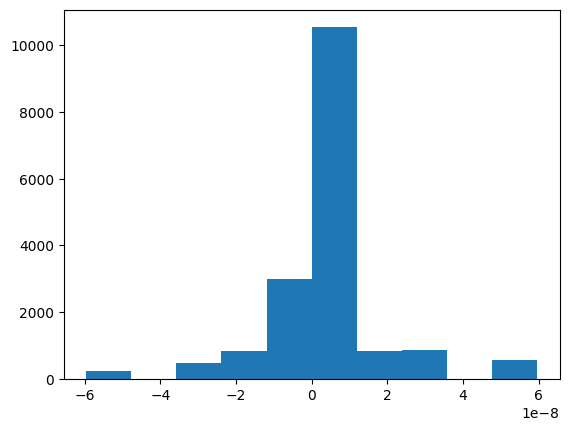

In [51]:
plt.hist(diff[~ltz_msk].cpu().numpy().ravel())
2**-23  # this is float32 precision, roughly

Aha!  So now we are at machine precision if you just ignore the zeros-ies

In [52]:
x1, p1 = set_coeffs_for_lstsq_solution_test(model, grid_ins, grid_outs, filterzeros=True)
x2, p2 = set_coeffs_for_lstsq_solution_test(model2, grid_ins, grid_outs, filterzeros=True)

torch.sum(torch.isfinite(p1))/p1.shape.numel(), torch.sum(torch.isfinite(p2))/p2.shape.numel()

Sequential(
  (0): Linear(in_features=3, out_features=3, bias=True)
  (1): LogLayer()
  (2): Linear(in_features=3, out_features=35, bias=False)
  (3): ExpLayer()
)
Sequential(
  (0): Linear(in_features=3, out_features=3, bias=True)
  (1): ExpandToPoly()
)


(tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))

In [53]:
torch.testing.assert_close(p1, p2)

They match!

In [71]:
s1 = set_coeffs_for_lstsq_solution_test(model, grid_ins, grid_outs, filterzeros=True, stage1only=False)
s2 = set_coeffs_for_lstsq_solution_test(model2, grid_ins, grid_outs, filterzeros=True, stage1only=False)

torch.testing.assert_close(s1.solution, s2.solution)

Sequential(
  (0): Linear(in_features=3, out_features=3, bias=True)
  (1): LogLayer()
  (2): Linear(in_features=3, out_features=35, bias=False)
  (3): ExpLayer()
)
Sequential(
  (0): Linear(in_features=3, out_features=3, bias=True)
  (1): ExpandToPoly()
)


And so do the solutions! What does the model then give?

nan

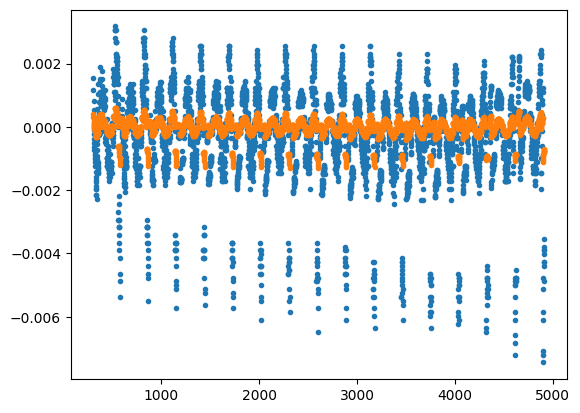

In [72]:
plt.plot((model(ins_plot) - outs_plot).cpu().detach(), '.')

nn.MSELoss().to(torch_device, dtype=torch.float32)(model(grid_ins), grid_outs).item()

1.0737743423305801e-06

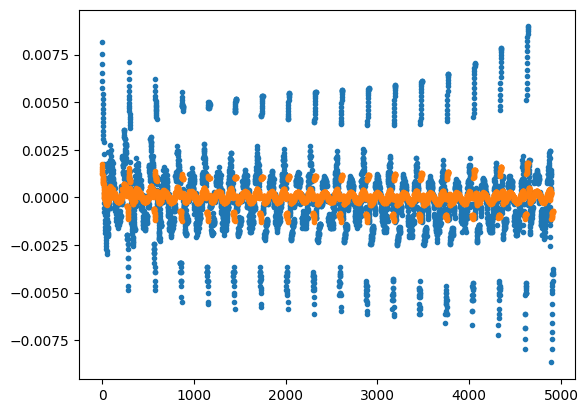

In [73]:
plt.plot((model2(ins_plot) - outs_plot).cpu().detach(), '.')

nn.MSELoss().to(torch_device, dtype=torch.float32)(model2(grid_ins), grid_outs).item()

The top outliers are missing from the logexp model, but I suppose then those are negative parts of the grid? Probably fixable by fiddling with scale anyway.

## Training Coeffs

In [81]:
inscale = [(float(grid_ins[...,i].min()), float(grid_ins[...,i].max())) for i in range(grid_ins.shape[-1])]
outscale = [(float(grid_outs[...,i].min()), float(grid_outs[...,i].max())) for i in range(grid_outs.shape[-1])]
model = RescalingLogLinearPolyModel(inscale, outscale, 4, fixpolypwr=True).to(torch_device, dtype=torch.float32)
model.set_coeffs_for_lstsq_solution(grid_ins, grid_outs, filterzeros=True)

model = batch_train_from_pool(model, 1024*10, 10000, 100,mask_nans=True,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-6, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.5, threshold=.005))

#training_plots(model)
#training_plots(model, residualsplot=False, skipstart=200);

  0%|          | 0/10000 [00:00<?, ?it/s]

Doh, nans in training

In [124]:
def batch_train_from_pool_nans(model, batch_size, n_batches, validation_period, 
                          pool=(grid_ins, grid_outs), valids=(grid_ins, grid_outs),
                          loss_fcn=None, optimizer=None, scheduler_gen=None, seed=42, shuffle=False, mask_nans=False):
    model = model.to(torch_device)
    
    if isinstance(seed, np.random.Generator):
        rng = seed
    else:
        rng = np.random.default_rng(seed)
        
    if loss_fcn is None:
        loss_fcn = model.loss_fcn = nn.MSELoss().to(torch_device, dtype=torch.float32)
    if optimizer is None:
        optimizer = model.optimizer = torch.optim.Adam(model.parameters())
    elif callable(optimizer):
        optimizer = optimizer(model)

    if scheduler_gen is None:
        scheduler = None
    else:
        scheduler = model.scheduler = scheduler_gen(optimizer)

    ins = pool[0]
    if len(ins.shape) != 2:
        ins = ins.reshape(ins.shape.numel()//ins.shape[-1], ins.shape[-1])
    outs = pool[1]
    if len(outs.shape) != 2:
        outs = outs.reshape(outs.shape.numel()//outs.shape[-1], outs.shape[-1])

    valid_ins = valids[0]
    if len(valid_ins.shape) != 2:
        valid_ins = valid_ins.reshape(valid_ins.shape.numel()//valid_ins.shape[-1], valid_ins.shape[-1])
    valid_outs = valids[1]
    if len(valid_outs.shape) != 2:
        valid_outs = valid_outs.reshape(valid_outs.shape.numel()//valid_outs.shape[-1], valid_outs.shape[-1])

    if not hasattr(model, 'batchis'):
        model.batchis = []
    if not hasattr(model, 'losses'):
        model.losses = []
        
    if not hasattr(model, 'batchis_validation'):
        model.batchis_validation = []
    if not hasattr(model, 'loss_validation'):
        model.loss_validation = []
        
    if not hasattr(model, 'learning_rates'):
        model.learning_rates = []

    llr = optimizer.param_groups[0]['lr']
    model.learning_rates.append((0, llr))
        
    pbar = tqdm(list(range(n_batches)))
    for batchi in pbar:
        if shuffle:
            rng.shuffle(idxs)
            samples = idxs[:batch_size]
        else:
            samples = rng.integers(ins.shape[0], size=batch_size)
            
        inb = ins[samples]
        outb = outs[samples]

        pred = model(inb)

        # if there are any nans, filter them out here.
        nanmsk = torch.all(torch.isfinite(pred), 1)
        if torch.sum(nanmsk)>0:
            assert torch.sum(nanmsk) > nanmsk.shape.numel()*0.5, "More than half of the inputs yield nans!"
            pred2 = model(inb[nanmsk])
            loss = loss_fcn(pred2, outb[nanmsk])
        else:
            loss = loss_fcn(pred, outb)

        model.batchis.append(batchi)
        model.losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if batchi % validation_period == 0 or batchi == (n_batches-1):
            with torch.no_grad():
                model.eval()
                model.batchis_validation.append(batchi)
                valid_pred = model(valid_ins)
                vnanmsk = torch.all(torch.isfinite(valid_pred), 1)
                model.loss_validation.append(loss_fcn(valid_pred[vnanmsk], valid_outs[vnanmsk]).item())

            if scheduler is not None:
                scheduler.step(model.loss_validation[-1])
                if llr != scheduler.get_last_lr()[-1]:
                    model.learning_rates.append((batchi, scheduler.get_last_lr()[-1]))
                    llr = model.learning_rates[-1][1]

            pbar.set_description(f'validation loss: {model.loss_validation[-1]}, lr: {llr}')
            pbar.refresh()
        
    model.eval()
    return model



  0%|          | 0/10000 [00:00<?, ?it/s]

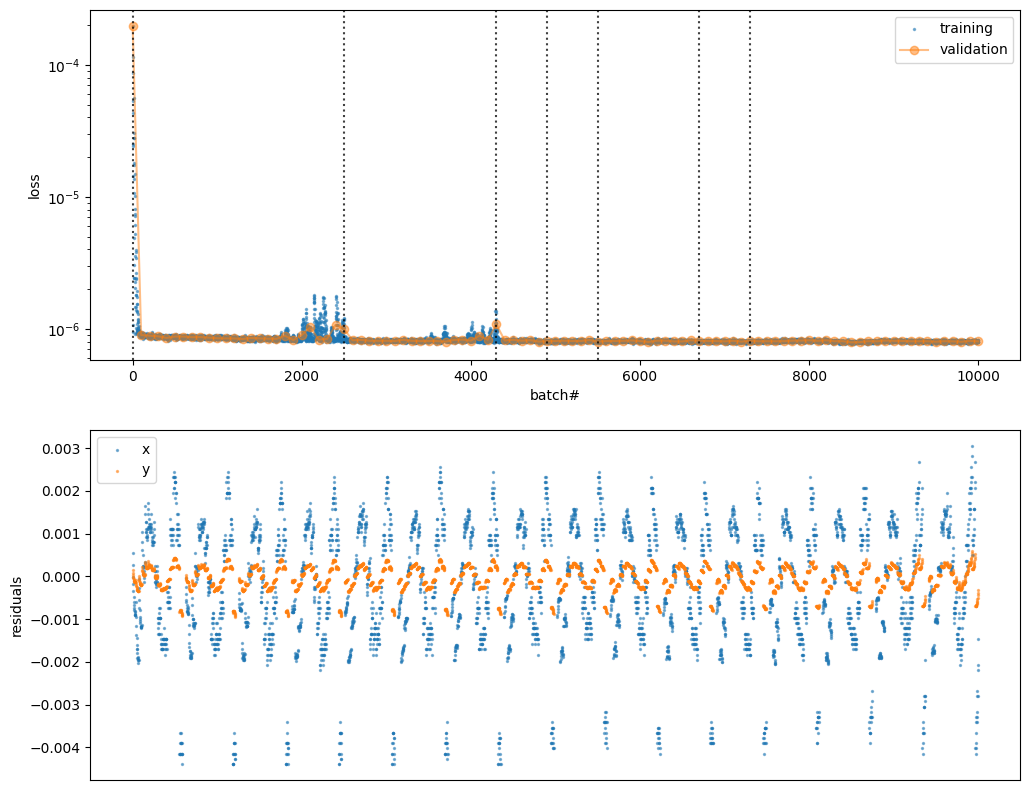

In [125]:
model = RescalingLogLinearPolyModel(inscale, outscale, 4, fixpolypwr=True).to(torch_device, dtype=torch.float32)
model.set_coeffs_for_lstsq_solution(grid_ins, grid_outs, filterzeros=True)

model = batch_train_from_pool_nans(model, 1024*10, 10000, 100,mask_nans=True,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-6, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.5, threshold=.005))

training_plots(model);

Huzzah!  What about without pre-setting coefficients?

  0%|          | 0/100000 [00:00<?, ?it/s]

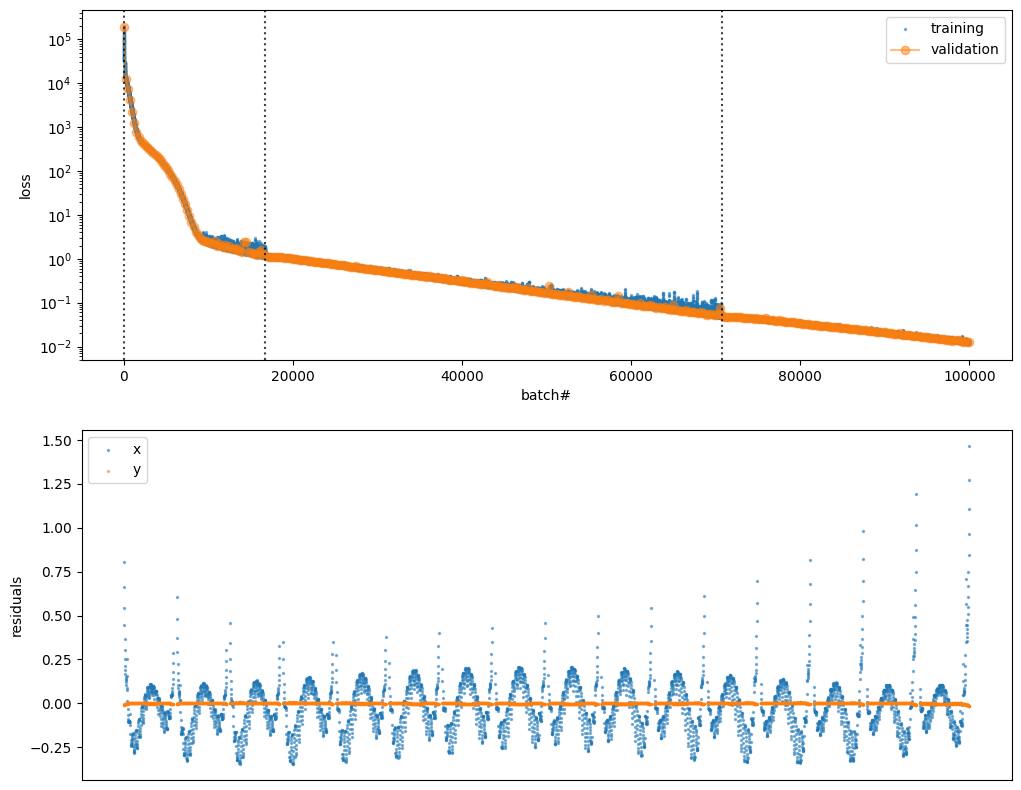

In [127]:
model = RescalingLogLinearPolyModel(inscale, outscale, 4, fixpolypwr=True).to(torch_device, dtype=torch.float32)

model = batch_train_from_pool_nans(model, 1024*10, 100000, 250,mask_nans=True,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-3, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=3, factor=.2, threshold=.001))

training_plots(model);

Now try allowing the powers to float?